<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Ico_3p</font></h2> 

In [1]:
from ipy_oxdna.umbrella_sampling import ComUmbrellaSampling, MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager, Simulation, Observable
from ipy_oxdna.wham_analysis import collect_coms
import os
import matplotlib.pyplot as plt
from ipy_oxdna.vmmc import *
from collections import Counter
from ipy_oxdna.parameter_search import * 
import numpy as np
from skopt import Optimizer
from skopt.space import Categorical, Space
from scipy.special import logsumexp
from copy import deepcopy
from numba import jit
plt.style.use(['science', 'no-latex', 'bright'])
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/ico_3p/')

system_name = 'inital_umbrella'

conditions = ['k05_xmax55_nwin56_50C']

systems = [f'{condition}' for condition in conditions]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


monomer_1_patch_1 = '11674,11666,11667,11668,11669,11670,11671,11672,11673'
monomer_1_patch_2 = '12945,12953,12946,12947,12948,12949,12950,12951,12952'
monomer_1_patch_3 = '13320,13328,13321,13322,13323,13324,13325,13326,13327'

monomer_2_patch_1 = '6655,6663,6656,6657,6658,6659,6660,6661,6662'
monomer_2_patch_2 = '6358,6350,6351,6352,6353,6354,6355,6356,6357'
monomer_2_patch_3 = '5752,5744,5745,5746,5747,5748,5749,5750,5751'

monomer_1_patch_1 = ','.join(sorted(monomer_1_patch_1.split(','))[::-1])
monomer_1_patch_2 = ','.join(sorted(monomer_1_patch_2.split(','))[::-1])
monomer_1_patch_3 = ','.join(sorted(monomer_1_patch_3.split(','))[::-1])

monomer_2_patch_1 = ','.join(sorted(monomer_2_patch_1.split(',')))
monomer_2_patch_2 = ','.join(sorted(monomer_2_patch_2.split(',')))
monomer_2_patch_3 = ','.join(sorted(monomer_2_patch_3.split(',')))

monomer_1 = f'{monomer_1_patch_1},{monomer_1_patch_2},{monomer_1_patch_3}'
monomer_2 = f'{monomer_2_patch_1},{monomer_2_patch_2},{monomer_2_patch_3}'


xmin = 0
xmax = 55
n_windows = 56
starting_r0 = 0.0910
stiff = 5
print_every = 1e4
temperature = '50C'
name = 'all_observables.txt'

pre_eq_steps = 5e6
eq_steps = 1e8
prod_steps = 1e9

verlet_skin = 0.5

hb_contact_filename = 'hb_contacts.txt'
particle_indexes = [monomer_1, monomer_2]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}' }
                            for _ in conditions]

equlibration_parameters_list = [{'steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

production_parameters_list = [{'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                           'print_conf_interval':f'{prod_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [ ]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, monomer_1, monomer_2,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None,
                               force_file=None, continue_run=False, name=name, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(gpu_mem_block=False)

In [ ]:
simulation_manager.terminate_all()

In [ ]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, monomer_1, monomer_2,
                               stiff, xmin, xmax, equlibration_parameters, print_every=print_every,
                               observable=True, protein=None, force_file=None, continue_run=False, name=name, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(gpu_mem_block=False)

In [ ]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, monomer_1, monomer_2,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None,
                             force_file=None, continue_run=False, name=name, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(gpu_mem_block=False)

In [ ]:
for sim in us_list[0].production_sims[:5]:
    sim.analysis.view_last()

In [ ]:
wham_dir = os.path.abspath('/scratch/matthew/ipy_oxDNA/src/wham/wham')
n_bins = '400'
tol = '1e-12'
n_boot = '0'

monomer_1 = f'{monomer_1_patch_1},{monomer_1_patch_2},{monomer_1_patch_3}'
monomer_2 = f'{monomer_2_patch_1},{monomer_2_patch_2},{monomer_2_patch_3}'


xmin = [0,10]
xmax = [10,45]
n_windows = 56
stiff = 15
print_every = 1e4
temperature = '50C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e8
prod_steps = 1e9

for us in us_list:
    us.observables_list = []
    us.com_distance_observable(monomer_1, monomer_2, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham_run(wham_dir, xmi, xma, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 2

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot)

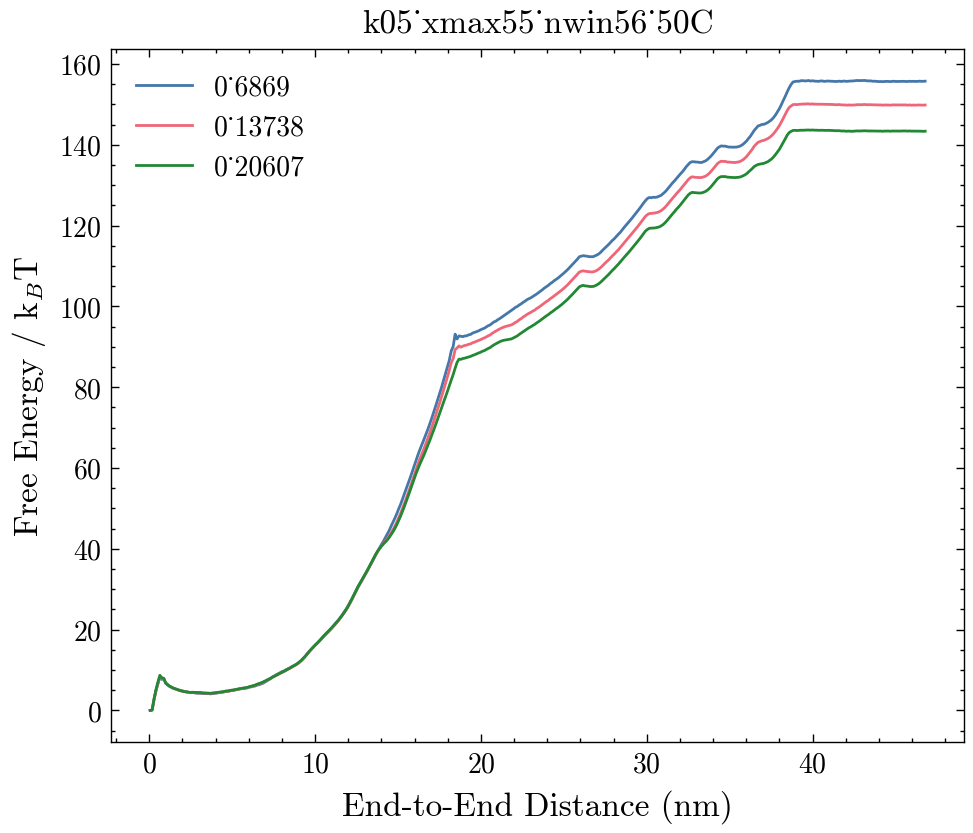

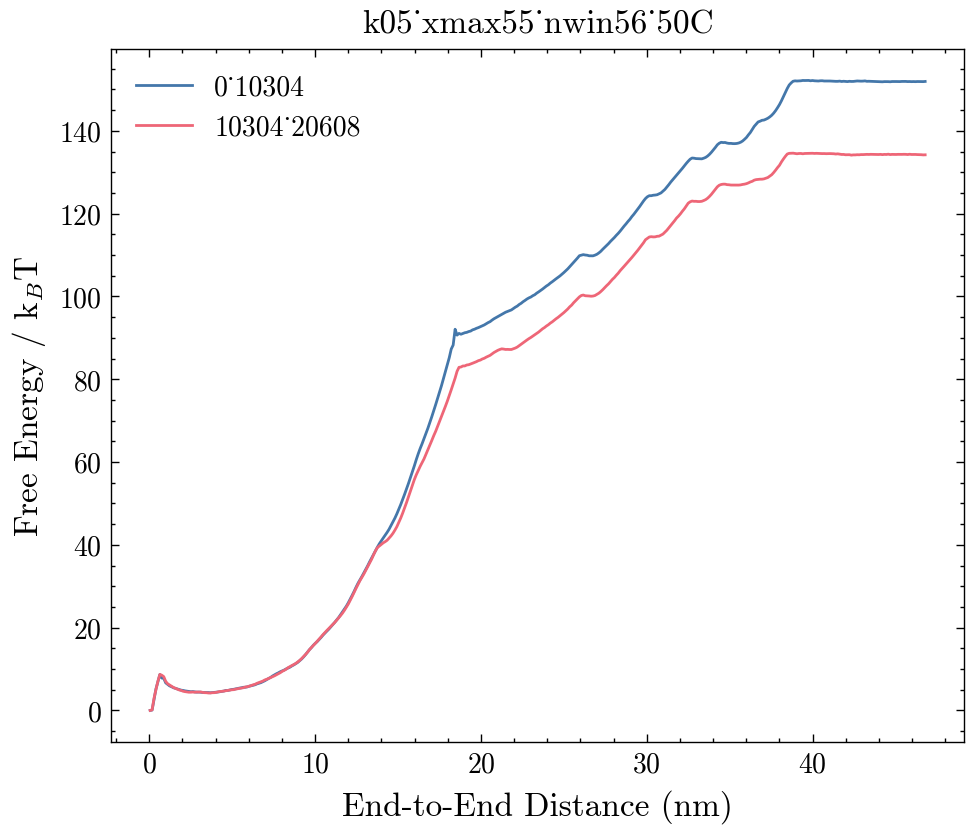

In [4]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

In [ ]:
for us in us_list:
    us.plot_free()

In [ ]:
temp_range = np.linspace(45, 65, 41)
temp_range

In [ ]:
us_list[0].obs_df = new_df

In [ ]:
us_list[0].get_r0_values()
us_list[1].get_r0_values()
new_r0 = us_list[0].r0 + us_list[1].r0
us_list[0].r0 = new_r0

In [ ]:
us_list[0].r0 = list(np.linspace(0,10,57)[1:]) + us_list[1].r0

In [ ]:
len(us_list[0].r0)

In [136]:
xmin = 0
xmax = 55
temp_range = np.linspace(45, 65, 10)
# temp_range = np.array([45, 50])
# temp_range = np.array([20, 30, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 70, 80])
n_bins = 200
max_hb = 27
umbrella_stiff = 0.5
epsilon = 1e-12
convergence_slice = 1

us_list[0].wham_cont_and_disc_temp_interp_converg_analysis(convergence_slice, temp_range,
                                                           n_bins, xmin, xmax, umbrella_stiff,max_hb,
                                                           epsilon=epsilon, reread_files=False, max_iterations=1000000)

# us_list[0].discrete_temp_interp_converg_analysis(convergence_slice, max_hb, temp_range, reread_files=False, all_observables=True)


temp_idx=0
temp_idx=1
temp_idx=2
temp_idx=3
temp_idx=4
temp_idx=5
temp_idx=6
temp_idx=7
temp_idx=8
temp_idx=9


WHAM | 0/? [00:00<?, ?it/s]/scratch/matthew/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py:1216: RuntimeWarning: invalid value encountered in true_divide
  p_x = numerator / np.sum(denominator, axis=1)
WHAM | 0/? [00:00<?, ?it/s, Convergence: nan / 1e-12]


Converged in [1] iterations


ValueError: array must not contain infs or NaNs

In [119]:
truncated_kinetic_energy, truncated_umbrella_bias = us_list[0].wham_temperature_interpolation(temp_range, n_bins, xmin, xmax, umbrella_stiff, max_hb, epsilon=1e-7, reread_files=False, all_observables=False, max_iterations=100000)

In [125]:
np.array(truncated_kinetic_energy).shape

(56, 100001)

In [39]:
us_list[0].get_com_distance_by_window()

In [60]:
us_list[0].r0

[0.982,
 1.964,
 2.946,
 3.929,
 4.911,
 5.893,
 6.875,
 7.857,
 8.839,
 9.821,
 10.804,
 11.786,
 12.768,
 13.75,
 14.732,
 15.714,
 16.696,
 17.679,
 18.661,
 19.643,
 20.625,
 21.607,
 22.589,
 23.571,
 24.554,
 25.536,
 26.518,
 27.5,
 28.482,
 29.464,
 30.446,
 31.429,
 32.411,
 33.393,
 34.375,
 35.357,
 36.339,
 37.321,
 38.304,
 39.286,
 40.268,
 41.25,
 42.232,
 43.214,
 44.196,
 45.179,
 46.161,
 47.143,
 48.125,
 49.107,
 50.089,
 51.071,
 52.054,
 53.036,
 54.018,
 55.0]

In [66]:
def get_pot_energy(com_dist_values, r0, k):
    return 0.5 * k * (com_dist_values - r0)**2

com_dist_values = np.array([inner_list['com_distance'] for inner_list in us_list[0].obs_df])
r0 = np.array(us_list[0].r0)

pot_energy = []
for i in range(len(us_list[0].r0)):
    pot_energy.append(get_pot_energy(com_dist_values[i], r0[i], 0.5))


In [94]:
force_bias = np.array(pot_energy) / (n_particles_in_system/2)

In [93]:
force_bias[1]

array([1.40185600e-02, 2.66978890e-01, 5.71927225e-02, ...,
       1.42802500e-04, 1.70734240e-01, 1.36773025e-02])

In [80]:
force_bias[1].tolist()[1] / 0.000039

6845.612564102562

In [79]:
n_particles_in_system/2

6792.0

In [89]:
us_list[0].get_bias_potential_value(0, 55,56, umbrella_stiff)

In [97]:
us_list[0].umbrella_bias[1] / (n_particles_in_system) * 2

,0
0,2.063981e-06
1,3.930785e-05
2,8.420601e-06
3,8.434691e-06
4,2.304183e-06
...,...
20534,7.586720e-08
20535,6.748941e-06
20536,1.948837e-06
20537,3.904962e-09


In [42]:
np.array(new_energy_per_window)

array([[[0.13399355, 0.1338271 , 0.13314067, ..., 0.13434459,
         0.13486715, 0.13466154],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.13453279, 0.13441297, 0.13382661, ..., 0.13381977,
         0.13383372, 0.13419779],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.13425562, 0.13422779, 0.13387304, ..., 0.13397743,
         0.13390188, 0.13379895],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.13311221, 0.13333052, 0.13302348, ..., 0.13386075,
         0.13411588, 0.13438913],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.13501973, 0.13520326, 0.13448507, ..., 0.13319985,
         0.1332368 , 0.13343307],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.133570

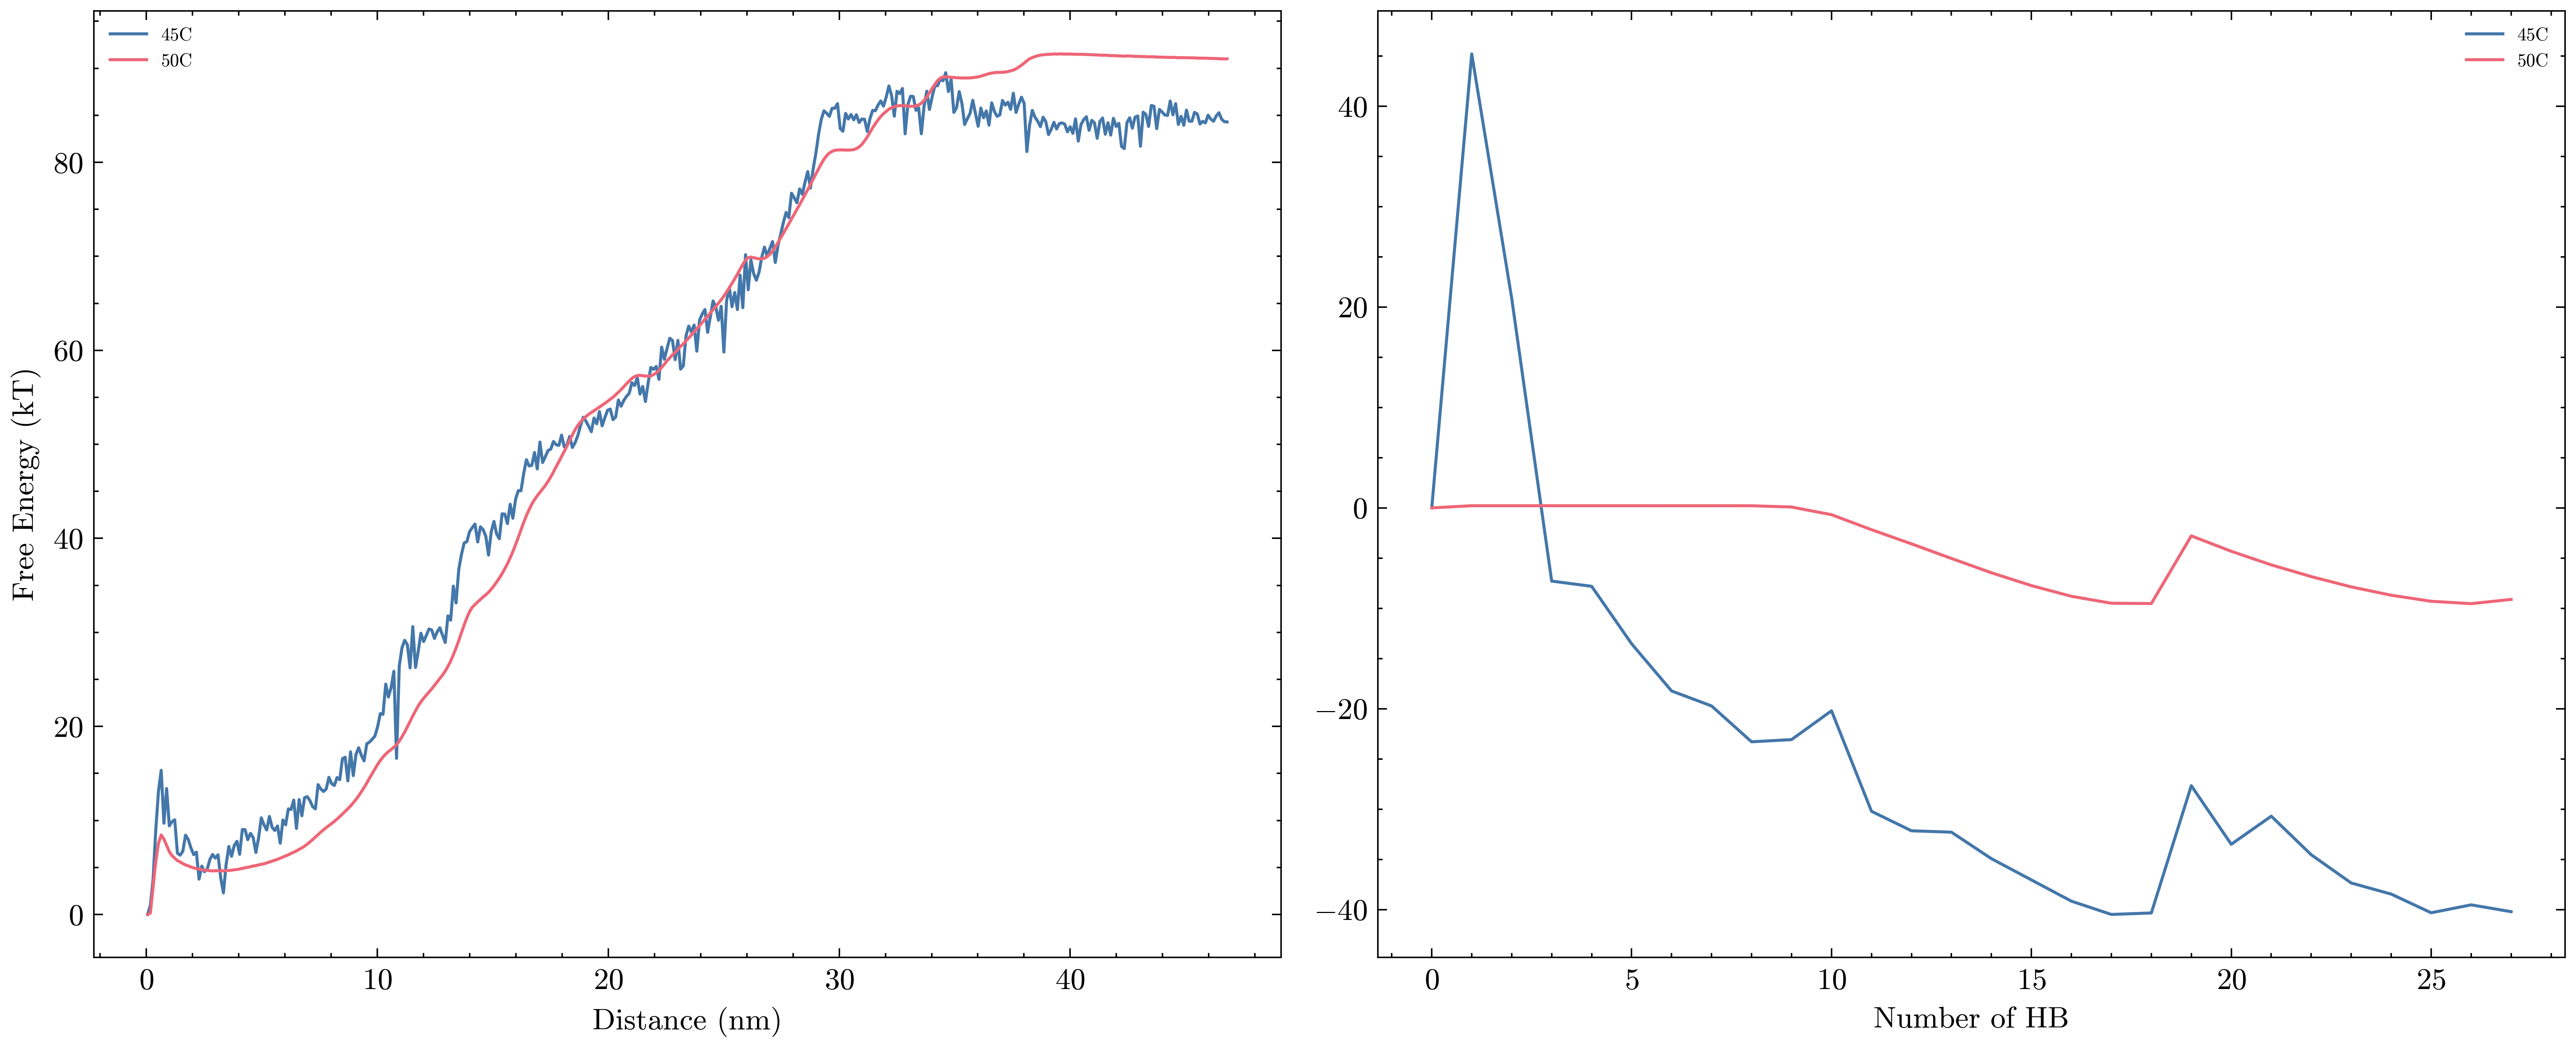

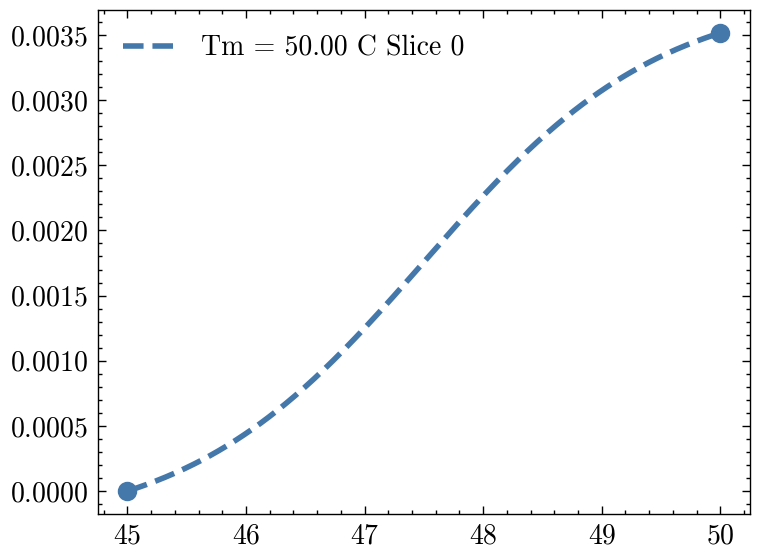

In [135]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=n_bins)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(12,5), tight_layout=True)
fig, ax = plt.subplots(dpi=200, figsize=(4,3), tight_layout=True)

ax1.set_xlabel('Distance (nm)')
ax2.set_xlabel('Number of HB')

ax1.set_ylabel('Free Energy (kT)')
# ax2.set_ylabel('Free Energy (kT)')

# ax1.set_xlim(-0.6,14.5)
# ax2.set_xlim(-0.6,29)
# ax1.set_ylim(-0.6,20)

for idx, free in enumerate(us_list[0].convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index], label=f'{temp_val}C') 
        else:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index])
        
ax1.legend(fontsize=6)


for idx, free_discrete in enumerate(us_list[0].convergence_discrete_free_energy):
    for f_discrete, temp_val in zip(free_discrete, temp_range):
        if idx == 0:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0], label=f'{temp_val}C')
        else:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0])
ax2.legend(fontsize=6)

label = ''

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us_list[0].convergence_inverted_finfs, us_list[0].convergence_x_fit, us_list[0].convergence_y_fit, us_list[0].convergence_Tm)):
    ax.scatter(temp_range, inverted_finfs, marker='o')
    ax.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    # ax.axvline(x=Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {Tm:.2f} °C')
    ax.legend()   

In [ ]:
us_list[0].production_sims[0].analysis.view_last()

In [ ]:
us_list[0].convergence_discrete_free_energy

In [ ]:
for sim in us_list[0].pre_equlibration_sims[0:1]:
    sim.analysis.view_init()

In [7]:
for us in us_list:
    us.observables_list = []
    us.com_distance_observable(monomer_1, monomer_2, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.kinetic_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

In [ ]:
df_1 = us_list[0].obs_df
df_2 = us_list[1].obs_df
new_df = df_1 + df_2

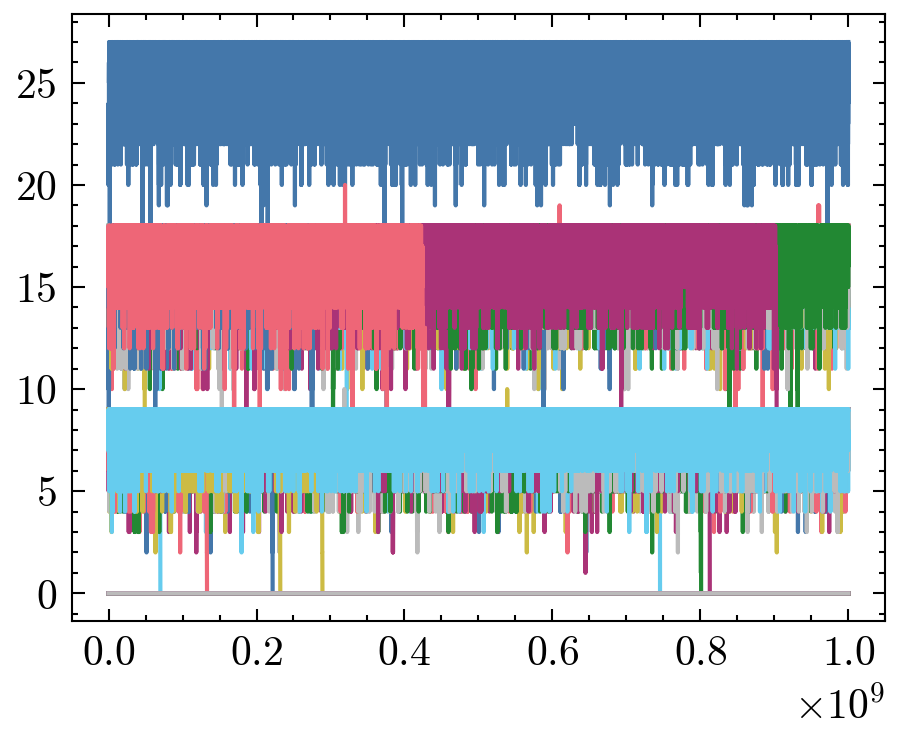

In [17]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]

my_obs = all_observables[0]

fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(my_obs):
    plt.plot(obs['steps'], obs['hb_list'].rolling(window=1).mean(), label=f'{idx}', linewidth=1)
# plt.legend(fontsize=1)

In [ ]:
us_list[1].read_hb_contacts()

In [ ]:
min_len = min([len(inner_list) for inner_list in us_list[1].hb_contacts_by_window.values()])
truncated_hb_contacts_by_window = np.array([value[:min_len] for value in us_list[1].hb_contacts_by_window.values()]).squeeze()

fig, ax = plt.subplots(dpi=300)
for hb_contacts in truncated_hb_contacts_by_window:
    
    H, bins = np.histogram(hb_contacts, bins=100)
    ax.plot(bins[1:], H)
ax.set_xlim(-0.05, 1)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a figure for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Side length of the cube
a = 30

# Coordinates for the cube
cube = np.array([[0, 0, 0], [a, 0, 0], [a, a, 0], [0, a, 0],  # Bottom face
                 [0, 0, a], [a, 0, a], [a, a, a], [0, a, a]]) # Top face

# Lines to connect the corners of the cube
lines = [[cube[i], cube[j]] for i, j in [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
                                         (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
                                         (0, 4), (1, 5), (2, 6), (3, 7)]] # Sides

# Plot the cube
for line in lines:
    ax.plot3D(*zip(*line), color="b")

# Create a sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
radius = a / 2 * np.sqrt(3)

# Adjust the sphere coordinates to be centered in the cube and with correct radius
x_corrected = radius * np.cos(u) * np.sin(v) + a/2
y_corrected = radius * np.sin(u) * np.sin(v) + a/2
z_corrected = radius * np.cos(v) + a/2

# Plot the sphere
ax.plot_surface(x, y, z, color='r', alpha=0.3)

# Set plot limits and labels
ax.set_xlim([0, a])
ax.set_ylim([0, a])
ax.set_zlim([0, a])
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()


In [ ]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

In [ ]:
sim.oxpy_run.cms_obs((monomer_1_patch_1, monomer_2_patch_1), name='com_distance.txt', print_every=int(print_every))
sim.build(clean_build='force')
sim.oxpy_run.run()

In [ ]:
sim.oxpy_run.process.terminate()

In [ ]:
A = 0.34
B = 2
cupy_array = np.random.random((2, 100, 3))
cupy_array = A + (B-A) * cupy_array

In [ ]:
A = 0
B = 2.4
# cupy_array = np.random.random((2, 9, 3))
# cupy_array = A + (B-A) * cupy_array
new_pos = np.full((1), 1.5)
# new_pos = np.full((1, 9, 3), 1.5)

# pos = np.zeros((cupy_array.shape[1], cupy_array.shape[2]), dtype=np.float64)
# np.subtract(cupy_array[0], cupy_array[1], out=pos, dtype=np.float64)
# new_pos = np.linalg.norm(pos, axis=1)
r0 = np.full(new_pos.shape, 1.2*1.5)
gamma = 58.7
denominator = 1 + np.exp((new_pos - r0)*gamma)
term = 1 / denominator
final = np.sum(term) / np.float64(cupy_array.shape[1])
print(final)
print(new_pos)

def op(new_pos, gamma, r0, shape):
    return np.sum(1 / (1 + np.exp((new_pos - r0*shape)*gamma))) / np.float64(new_pos.shape[0])

In [ ]:
def op(new_pos, gamma, r0, shape):
    return np.sum(1 / (1 + np.exp((new_pos - r0*shape)*gamma))) / np.float64(new_pos.shape[0])

r0 = 1.2
shape = 1.5
gamma = 58.7

x_vals = np.linspace(0, 2.4, 100)
y_vals = [op(np.array([x_val]), gamma, r0, shape) for x_val in x_vals]


plt.plot(x_vals, y_vals)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def op(new_pos, gamma, r0, shape):
    return np.sum(1 / (1 + np.exp((new_pos - r0*shape)*gamma))) / np.float64(new_pos.shape[0])

def v_gauss(new_pos, gamma, r0, shape):
    return np.exp(-gamma * (new_pos - r0*shape)**2

gamma_values = np.arange(50, 71, 10)
r0_values = np.arange(0.8, 1.5, 0.3)
shape_values = np.arange(0.5, 2.2, 0.8)

x_vals = np.linspace(0, 5, 100)

fig, axs = plt.subplots(len(r0_values), len(shape_values), figsize=(15, 15), dpi=300)

for i, r0 in enumerate(r0_values):
    for j, shape in enumerate(shape_values):
        for gamma in gamma_values:
            y_vals = [op(np.array([x_val]), gamma, r0, shape) for x_val in x_vals]
            axs[i, j].plot(x_vals, y_vals, label=f'gamma={gamma}')
        axs[i, j].legend(fontsize=6)
        axs[i, j].set_title(f'r0={r0}, shape={shape}')

plt.tight_layout()
plt.show()

The Gaussian biasing potential \( V \) in a metadynamics simulation is given by:

$$
V(x_1, y_1, z_1, x_2, y_2, z_2, r_0, \gamma, \lambda, h, \sigma, s_{\text{Prev}}) = h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right)
$$

where \( CV \) is the collective variable defined as:

$$
CV(x_1, y_1, z_1, x_2, y_2, z_2, r_0, \gamma, \lambda) = \frac{1}{1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)}
$$

and \( r_{\text{Bar}} \) is the Euclidean distance between the two particles:

$$
r_{\text{Bar}}(x_1, y_1, z_1, x_2, y_2, z_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}
$$

To apply a biasing force to the particles, we need to calculate the gradient of the potential \( V \) with respect to the coordinates of the particles. The gradient of \( V \) with respect to \( x_1 \) is:

$$
\frac{\partial V}{\partial x_1} = -\frac{\partial}{\partial x_1} \left[ h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right) \right]
$$

This derivative can be expanded using the chain rule:

$$
\frac{\partial V}{\partial x_1} = -h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right) \cdot \left(-\frac{2(s_{\text{Prev}} - CV)}{2\sigma^2}\right) \cdot \frac{\partial CV}{\partial x_1}
$$

The derivative of \( CV \) with respect to \( x_1 \) is:

$$
\frac{\partial CV}{\partial x_1} = \frac{\partial}{\partial x_1} \left[ \frac{1}{1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)} \right]
$$

This derivative can be simplified further using the chain rule and the derivative of the exponential function:

$$
\frac{\partial CV}{\partial x_1} = -\frac{\gamma \cdot \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)}{\left(1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)\right)^2} \cdot \frac{\partial r_{\text{Bar}}}{\partial x_1}
$$

And the derivative of \( r_{\text{Bar}} \) with respect to \( x_1 \) is:

$$
\frac{\partial r_{\text{Bar}}}{\partial x_1} = \frac{x_1 - x_2}{r_{\text{Bar}}}
$$

Putting it all together, the gradient of the biasing potential \( V \) with respect to \( x_1 \) is:

$$
\frac{\partial V}{\partial x_1} = h \cdot \exp\left(-\frac{(s_{\text{Prev}} - CV)^2}{2\sigma^2}\right) \cdot \frac{(s_{\text{Prev}} - CV)}{\sigma^2} \cdot \frac{\gamma \cdot \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)}{\left(1 + \exp\left(\gamma \cdot (r_{\text{Bar}} - \lambda \cdot r_0)\right)\right)^2} \cdot \frac{x_1 - x_2}{r_{\text{Bar}}}
$$

This is the force component in the \( x \)-direction that would be applied to particle 1 due to the biasing potential in the metadynamics simulation. The force components in the \( y \) and \( z \) directions can be calculated similarly by taking the partial derivatives with respect to \( y_1 \) and \( z_1 \), respectively.

where \( \nabla V \) is the gradient of the potential \( V \) with respect to the coordinates of the particles, and the negative sign arises because the force is in the direction of the steepest descent of the potential energy surface.

So, the force in each direction \( F_x, F_y, F_z \) can be calculated by the following components:

$$
F_x = -\frac{\partial V}{\partial x_1} \cdot \frac{x_1 - x_2}{r_{\text{Bar}}}
$$

$$
F_y = -\frac{\partial V}{\partial y_1} \cdot \frac{y_1 - y_2}{r_{\text{Bar}}}
$$

$$
F_z = -\frac{\partial V}{\partial z_1} \cdot \frac{z_1 - z_2}{r_{\text{Bar}}}
$$